## Import libraries

In [1]:
# Imports
import re
import string
import json
from datetime import datetime
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.nn import Module
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.init import xavier_uniform_
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from nltk.corpus import stopwords

device = 'cpu'

import random

random.seed(26)
np.random.seed(62)
torch.manual_seed(2021)

## Load data

In [2]:
ben_train_df = pd.read_csv('save/bengali_hatespeech_sample_train_preprocessed.csv')
ben_test_df = pd.read_csv('save/bengali_hatespeech_sample_test_preprocessed.csv')

display(ben_train_df.head())

,sentence,hate,category
0,11831 114 8255 1729,1,religion
1,3925 14369 202 4702 1328 11395 11706 3973 5360...,1,"Meme, TikTok and others"
2,12219 12568 10709 1507 7799,1,religion
3,9663 5675 9081 946,1,religion
4,7756 2189,1,crime


In [3]:
# remove empty texts
ben_train_df = ben_train_df[ben_train_df.sentence.str.len() > 0]
# extract sentences and labels
train_sentences = [text.split() for text in ben_train_df['sentence']]
train_labels = ben_train_df['hate'].to_numpy()

# remove empty texts
ben_test_df = ben_test_df[ben_test_df.sentence.str.len() > 0]
# extract sentences and labels
test_sentences = [text.split() for text in ben_test_df['sentence']]
test_labels = ben_test_df['hate'].to_numpy()

print('Train data:')
print(train_sentences[:3])
print(train_labels)
print()
print('Test data:')
print(test_sentences[:3])
print(test_labels)

Train data:
[['11831', '114', '8255', '1729'], ['3925', '14369', '202', '4702', '1328', '11395', '11706', '3973', '5360', '4025', '4992'], ['12219', '12568', '10709', '1507', '7799']]
[1 1 1 ... 1 1 1]

Test data:
[['1167', '2937', '14881', '13830', '2393', '6321'], ['1820', '5675', '1397', '12128', '14806'], ['14881', '13002', '2871', '7683', '6901', '5917', '13787', '9230', '3402']]
[1 1 0 ... 0 0 0]


## Prepare vocab set

In [4]:
# load mapping {word -> id} and {id -> word}
with open('save/bengali_word_to_int_dict.json') as f:
    word_to_int = json.load(f)
with open('save/bengali_int_to_word_dict.json') as f:
    int_to_word = json.load(f)
    int_to_word = {int(k) : v for k, v in int_to_word.items()}

# get vocab_size
vocab_size = len(word_to_int)
print(f'vocab_size: {vocab_size}')

vocab_size: 15190


In [5]:
train_sentences = [[int(word_id) for word_id in sentence] for sentence in train_sentences]
test_sentences = [[int(word_id) for word_id in sentence if int(word_id) in int_to_word] for sentence in test_sentences]

## Hyper-parameters

In [6]:
embedding_path = 'save/embedding_weights.pt'
embedding_size = 300
att_dim = 150
learning_rate = 1e-4
batch_size = 32
epochs = 30

## Build datasets

In [7]:
class HOFDataset(Dataset):
    def __init__(self, sentences, labels):
        self.data = []
        for sentence, label in zip(sentences, labels):
            if len(sentence):
                self.data.append(
                    (torch.tensor(sentence, dtype=torch.long), 
                     torch.tensor(label, dtype=torch.float))
                )
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index]
    
def preprocess_batch(batch):
    texts, labels = list(zip(*batch))
    seq_lens = torch.tensor([len(text) for text in texts], dtype=torch.long)
    texts = pad_sequence(texts, padding_value=0)
    labels = torch.tensor(labels).unsqueeze(1)

    seq_lens, sorted_idx = seq_lens.sort(descending=True)
    texts = texts[:,sorted_idx]
    labels = labels[sorted_idx]
    return texts, seq_lens, labels

train_dataset = HOFDataset(train_sentences, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                          shuffle=True, collate_fn=preprocess_batch)

test_dataset = HOFDataset(test_sentences, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, 
                         shuffle=False, collate_fn=preprocess_batch)

## Network architecture

In [8]:
def mask_seq(seq_lens):
    mask = torch.zeros((len(seq_lens), max(seq_lens))).bool()
    for i, seq_len in enumerate(seq_lens):
        mask[i, seq_len:] = True
    return mask

## Encoder layer

In [9]:
class Encoder(Module):
    def __init__(self, embed_dim, num_heads, dropout, batch_first, norm_dim):
        super(Encoder, self).__init__()
        
        self.batch_first = batch_first
        self.norm_dim = norm_dim
        self.att = nn.MultiheadAttention(embed_dim=embed_dim,
                                         num_heads=num_heads,
                                         dropout=dropout,)
        self.fc = nn.Linear(embed_dim, embed_dim)
        self.fc.weight = xavier_uniform_(self.fc.weight)
    
    def forward(self, inp, pad_mask):
        # make batch second
        if self.batch_first:
            inp = inp.permute(1, 0, 2)        
        
        # inp, att_out: [seq dim, batch dim, embed dim]
        att_out, _ = self.att(inp, inp, inp, key_padding_mask=pad_mask)
        
        # out, fc_out: [batch dim, seq dim, embed dim]
        out = (att_out + inp).permute(1, 0, 2)
        out = F.layer_norm(out, out.shape[self.norm_dim:])
        out = F.layer_norm(self.fc(out) + out, out.shape[self.norm_dim:])
        
        # restore the original shape
        if not self.batch_first:
            out = out.permute(1, 0, 2)
        return out

### Load hindi vocab size

In [10]:
# get hindi_vocab_size
with open('../hindi_hindi/save/hindi_word_to_int_dict.json') as f:
    hindi_word_to_int = json.load(f)
hindi_vocab_size = len(hindi_word_to_int)

## Network architecture

### Positional Encoding

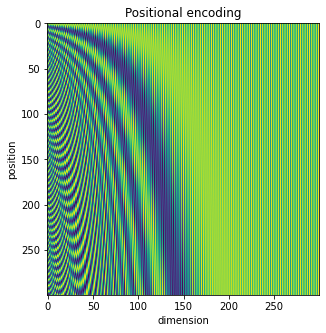

In [20]:
max_len = 300

def get_pe(p, i):
    k = i // 2
    if i % 2 == 0:
        return np.sin(p/(10000**(2*k/embedding_size)))
    else:
        return np.cos(p/(10000**(2*k/embedding_size)))

pe = np.zeros((embedding_size, max_len))
for p in range(max_len):
    for i in range(embedding_size):
        pe[i, p] = get_pe(p, i)
        
pe = pe.T # for easier addition in the future operations
pe = torch.tensor(pe, requires_grad=False).to(device)

### Architecture

In [21]:
# use the same architecture as hindi_hindi classifier
class Classifier(Module):
    def __init__(self):
        super(Classifier, self).__init__()

        self.embed = nn.Embedding(hindi_vocab_size, embedding_size)
        
        self.encoder_1 = Encoder(
            embed_dim=embedding_size,
            num_heads=10,
            dropout=0.7,
            batch_first=False,
            norm_dim=1,
        )
        self.encoder_2 = Encoder(
            embed_dim=embedding_size,
            num_heads=5,
            dropout=0.7,
            batch_first=False,
            norm_dim=1,
        )

        self.fc = nn.Linear(embedding_size, 1)

    def forward(self, inp, seq_lens):
        # add positional encoding
        # out: [seq dim, batch dim, embed dim]
        out = self.embed(inp)
        for i in range(out.shape[1]):
            out[:, i, :] += pe[:out.shape[0], :]
        # padding mask
        pad_mask = mask_seq(seq_lens)
        # encoder
        out = self.encoder_1(out, pad_mask)
        out = self.encoder_2(out, pad_mask)
        # predict
        out = self.fc(out)
        out = out.squeeze(2)
        pred = torch.zeros((out.size(1), 1))
        for i, seq_len in enumerate(seq_lens):
            pred[i, 0] = out[:seq_len, i].mean()
        return pred

In [22]:
# load pre-trained hindi classifier
hindi_clf = Classifier().to(device)
hindi_model_weight_path = '../hindi_hindi/save/hindi_hindi_final_clf.pt'
hindi_clf.load_state_dict(torch.load(hindi_model_weight_path, map_location=torch.device(device)))
print('Hindi classifier:')
print(hindi_clf.eval())

print()

# replace the embedding layer to make it a bengali classifier
bengali_embed = nn.Embedding(vocab_size, embedding_size)
bengali_clf = hindi_clf
bengali_clf._modules['embed'] = bengali_embed
print('Bengali classifier:')
print(bengali_clf.eval())

Hindi classifier:
Classifier(
  (embed): Embedding(19379, 300)
  (encoder_1): Encoder(
    (att): MultiheadAttention(
      (out_proj): _LinearWithBias(in_features=300, out_features=300, bias=True)
    )
    (fc): Linear(in_features=300, out_features=300, bias=True)
  )
  (encoder_2): Encoder(
    (att): MultiheadAttention(
      (out_proj): _LinearWithBias(in_features=300, out_features=300, bias=True)
    )
    (fc): Linear(in_features=300, out_features=300, bias=True)
  )
  (fc): Linear(in_features=300, out_features=1, bias=True)
)
Bengali classifier:
Classifier(
  (embed): Embedding(15190, 300)
  (encoder_1): Encoder(
    (att): MultiheadAttention(
      (out_proj): _LinearWithBias(in_features=300, out_features=300, bias=True)
    )
    (fc): Linear(in_features=300, out_features=300, bias=True)
  )
  (encoder_2): Encoder(
    (att): MultiheadAttention(
      (out_proj): _LinearWithBias(in_features=300, out_features=300, bias=True)
    )
    (fc): Linear(in_features=300, out_features

## Loss function and optimizer

In [23]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(bengali_clf.parameters(), lr=learning_rate)

## Measure performance on test data

In [24]:
def predict_test():
    losses = 0
    acc_cnt = 0
    cnt = 0
    preds = []
    true_labels = []
    for texts, seq_lens, labels in test_loader:
        pred = bengali_clf(texts.to(device), seq_lens).detach().to('cpu')
        loss = criterion(pred, labels)
        losses += loss.detach().item() * len(texts)
        acc_cnt += sum((pred > 0) == (labels > 0)).item()
        preds.extend(pred.view(-1))
        true_labels.extend(labels.view(-1))
        cnt += texts.size(1)
    
    preds = np.array(preds) > 0
    macro_f1 = f1_score(true_labels, preds, average='macro')
    weighted_f1 = f1_score(true_labels, preds, average='weighted')
    return losses / cnt, acc_cnt / cnt, macro_f1, weighted_f1

## Training

In [25]:
list_test_acc = []
early_stop = 5

for epoch in range(1, epochs + 1):
    losses = 0.
    acc_cnt = 0
    cnt = 0
    bengali_clf.train()
    for texts, seq_lens, labels in tqdm(train_loader):
        optimizer.zero_grad()
        pred = bengali_clf(texts.to(device), seq_lens)
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()
        losses += loss.detach().item() * len(texts)
        acc_cnt += sum((pred.to('cpu') > 0) == (labels > 0)).item()
        cnt += texts.size(1)

    epoch_loss = losses / cnt
    epoch_acc = acc_cnt / cnt
    test_loss, test_acc, test_macro_f1, test_weighted_f1 = predict_test()
    print(f'Epoch {epoch:2}: Train loss: {epoch_loss:.4f}, acc: {epoch_acc:.4f}. '
        f'Test loss: {test_loss:.4f}, acc: {test_acc:.4f}, '
        f'macro_f1: {test_macro_f1:.4f}, weighted_f1: {test_weighted_f1:.4f}',
        flush=True)

    list_test_acc.append(test_acc)
    if len(list_test_acc) > early_stop and max(list_test_acc[-early_stop:]) <= max(list_test_acc[:-early_stop]):
        print(f'Early stopping: test accuracy does not increase after {early_stop} epochs')
        break

  0%|          | 0/146 [00:00<?, ?it/s]/home/tung/miniconda3/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(
100%|██████████| 146/146 [00:20<00:00,  7.14it/s]


Epoch  1: Train loss: 1.2363, acc: 0.5533. Test loss: 0.9626, acc: 0.5798, macro_f1: 0.5731, weighted_f1: 0.5693


100%|██████████| 146/146 [00:26<00:00,  5.46it/s]


Epoch  2: Train loss: 1.0410, acc: 0.6724. Test loss: 0.9281, acc: 0.6597, macro_f1: 0.6597, weighted_f1: 0.6598


100%|██████████| 146/146 [00:26<00:00,  5.61it/s]


Epoch  3: Train loss: 0.9043, acc: 0.7295. Test loss: 0.8326, acc: 0.7054, macro_f1: 0.7043, weighted_f1: 0.7056


100%|██████████| 146/146 [00:25<00:00,  5.62it/s]


Epoch  4: Train loss: 0.7951, acc: 0.7825. Test loss: 0.8341, acc: 0.7163, macro_f1: 0.7101, weighted_f1: 0.7131


100%|██████████| 146/146 [00:25<00:00,  5.75it/s]


Epoch  5: Train loss: 0.7100, acc: 0.8189. Test loss: 0.8430, acc: 0.7248, macro_f1: 0.7174, weighted_f1: 0.7207


100%|██████████| 146/146 [00:24<00:00,  5.87it/s]


Epoch  6: Train loss: 0.6403, acc: 0.8507. Test loss: 1.0052, acc: 0.7016, macro_f1: 0.7016, weighted_f1: 0.7015


100%|██████████| 146/146 [00:25<00:00,  5.75it/s]


Epoch  7: Train loss: 0.5586, acc: 0.8651. Test loss: 0.9203, acc: 0.7302, macro_f1: 0.7291, weighted_f1: 0.7304


100%|██████████| 146/146 [00:25<00:00,  5.82it/s]


Epoch  8: Train loss: 0.5183, acc: 0.8824. Test loss: 0.9651, acc: 0.7333, macro_f1: 0.7303, weighted_f1: 0.7324


100%|██████████| 146/146 [00:24<00:00,  5.87it/s]


Epoch  9: Train loss: 0.4074, acc: 0.9009. Test loss: 1.0738, acc: 0.7240, macro_f1: 0.7235, weighted_f1: 0.7227


100%|██████████| 146/146 [00:25<00:00,  5.64it/s]


Epoch 10: Train loss: 0.3492, acc: 0.9208. Test loss: 1.1292, acc: 0.7310, macro_f1: 0.7294, weighted_f1: 0.7309


100%|██████████| 146/146 [00:27<00:00,  5.26it/s]


Epoch 11: Train loss: 0.3488, acc: 0.9238. Test loss: 1.2187, acc: 0.7070, macro_f1: 0.7070, weighted_f1: 0.7068


100%|██████████| 146/146 [00:25<00:00,  5.81it/s]


Epoch 12: Train loss: 0.2590, acc: 0.9434. Test loss: 1.2642, acc: 0.7349, macro_f1: 0.7291, weighted_f1: 0.7319


100%|██████████| 146/146 [00:25<00:00,  5.84it/s]


Epoch 13: Train loss: 0.2584, acc: 0.9410. Test loss: 1.2288, acc: 0.7318, macro_f1: 0.7300, weighted_f1: 0.7316


100%|██████████| 146/146 [00:25<00:00,  5.76it/s]


Epoch 14: Train loss: 0.2198, acc: 0.9507. Test loss: 1.3759, acc: 0.7078, macro_f1: 0.7075, weighted_f1: 0.7081


100%|██████████| 146/146 [00:25<00:00,  5.74it/s]


Epoch 15: Train loss: 0.2209, acc: 0.9487. Test loss: 1.4426, acc: 0.7357, macro_f1: 0.7338, weighted_f1: 0.7354


100%|██████████| 146/146 [00:26<00:00,  5.58it/s]


Epoch 16: Train loss: 0.1981, acc: 0.9577. Test loss: 1.3626, acc: 0.7233, macro_f1: 0.7229, weighted_f1: 0.7236


100%|██████████| 146/146 [00:24<00:00,  6.03it/s]


Epoch 17: Train loss: 0.1878, acc: 0.9571. Test loss: 1.4964, acc: 0.7279, macro_f1: 0.7278, weighted_f1: 0.7282


100%|██████████| 146/146 [00:25<00:00,  5.75it/s]


Epoch 18: Train loss: 0.1851, acc: 0.9625. Test loss: 1.3020, acc: 0.7364, macro_f1: 0.7359, weighted_f1: 0.7367


100%|██████████| 146/146 [00:24<00:00,  5.91it/s]


Epoch 19: Train loss: 0.1620, acc: 0.9652. Test loss: 1.3801, acc: 0.7457, macro_f1: 0.7423, weighted_f1: 0.7445


100%|██████████| 146/146 [00:24<00:00,  5.96it/s]


Epoch 20: Train loss: 0.1450, acc: 0.9687. Test loss: 1.3203, acc: 0.7473, macro_f1: 0.7459, weighted_f1: 0.7473


100%|██████████| 146/146 [00:26<00:00,  5.56it/s]


Epoch 21: Train loss: 0.1413, acc: 0.9743. Test loss: 1.3886, acc: 0.7450, macro_f1: 0.7428, weighted_f1: 0.7445


100%|██████████| 146/146 [00:24<00:00,  5.85it/s]


Epoch 22: Train loss: 0.0985, acc: 0.9815. Test loss: 1.4864, acc: 0.7364, macro_f1: 0.7360, weighted_f1: 0.7368


100%|██████████| 146/146 [00:25<00:00,  5.71it/s]


Epoch 23: Train loss: 0.0940, acc: 0.9833. Test loss: 1.5276, acc: 0.7442, macro_f1: 0.7431, weighted_f1: 0.7443


100%|██████████| 146/146 [00:25<00:00,  5.72it/s]


Epoch 24: Train loss: 0.0754, acc: 0.9839. Test loss: 1.6780, acc: 0.7271, macro_f1: 0.7271, weighted_f1: 0.7268


100%|██████████| 146/146 [00:26<00:00,  5.60it/s]


Epoch 25: Train loss: 0.0769, acc: 0.9843. Test loss: 1.6516, acc: 0.7403, macro_f1: 0.7398, weighted_f1: 0.7406
Early stopping: test accuracy does not increase after 5 epochs


In [ ]:
# save the word-embedding layer weights
embedding_weights = bengali_clf.embed.state_dict()
torch.save(embedding_weights, f'save/bengali_embedding_weights.pt')